# Testing Instructions for Demo

!!! This is a demo version of our project!!!

In our demo, we use a smaller subset of the original data, which we got from the training dataset of [this Kaggle competition](https://www.kaggle.com/competitions/aptos2019-blindness-detection/data). Our demo uses 696 images for training and 184 images for testing.

For our project, we tested the effectiveness of three different backbone models (ResNet50, EfficientNet-B3, Inception-V3) for identifying Diabetic Retinopathy Severity from retinal fundus images. In order to test our code, make sure that this notebook file is in the same directory as:

- The training data subset images folder (train_images_subset/)
- The testing data subset images folder (test_images_subset/)
- training labels subset CSV (train_split.csv)
- testing labels subset CSV (test_split.csv)

Run all the cells in this notebook to load and test all 3 backbone models and display their results. The code is device agnostic, so feel free to use either CPU or GPU, although using CPUs will noticably reduce the completion speed.

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pandas as pd
import os
from PIL import Image
from torchvision import models, transforms
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from torch.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [49]:
TRAIN_DATA_DIR = "train_images_subset"
TEST_DATA_DIR = "test_images_subset"
TRAIN_CSV = "train_split.csv"
TEST_CSV = "test_split.csv"
allModels = {}
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

# Dataset and Model Definitions

In [50]:
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["id_code"] + ".png"  # APTOS image format
        img_path = os.path.join(self.img_dir, img_name)

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = int(row["diagnosis"])
        return img, label

In [51]:
#   ORDINAL RESNET50
class OrdinalResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(weights="IMAGENET1K_V1")
        base.fc = nn.Identity()
        self.backbone = base
        self.ordinal_layer = nn.Linear(2048, 4)

    def forward(self, x):
        feats = self.backbone(x)
        logits = self.ordinal_layer(feats)
        return logits


#   ORDINAL EFFICIENTNET-B3
class OrdinalEfficientNetB3(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.efficientnet_b3(
            weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1
        )
        in_features = base.classifier[1].in_features
        base.classifier = nn.Identity()
        self.backbone = base
        self.ordinal_layer = nn.Linear(in_features, 4)

    def forward(self, x):
        feats = self.backbone(x)
        logits = self.ordinal_layer(feats)
        return logits
        
#   ORDINAL INCEPTION-V3
class OrdinalInceptionV3(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.inception_v3(weights="IMAGENET1K_V1", aux_logits=True)
        base.aux_logits = False
        base.fc = nn.Identity()
        self.backbone = base
        self.ordinal_layer = nn.Linear(2048, 4)

    def forward(self, x):
        feats = self.backbone(x)
        logits = self.ordinal_layer(feats)
        return logits

# Helper Functions

In [52]:
def qwk_score(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

def get_loaders(fold, train_transform, val_transform):
    train_dataset = RetinopathyDataset(f"fold_{fold + 1}_train.csv", TRAIN_DATA_DIR, train_transform)
    val_dataset   = RetinopathyDataset(f"fold_{fold + 1}_val.csv",   TRAIN_DATA_DIR, val_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    return train_loader, val_loader

def ordinal_encode(labels, num_classes=5):
    batch_size = labels.size(0)
    thresholds = torch.arange(num_classes-1).to(labels.device)
    return (labels.unsqueeze(1) > thresholds).float()

def ordinal_decode(logits):
    probs = torch.sigmoid(logits)
    return torch.sum(probs > 0.5, dim=1)

# Training Function

In [53]:
def train_one_fold_ordinal(model, train_loader, val_loader, fold, epochs=3, lr=1e-4, modelType="", all_models =None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler(device="cuda")

    criterion = nn.BCEWithLogitsLoss()

    best_qwk = -1
    best_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # convert numeric label → 4-dim ordinal label
            ord_labels = ordinal_encode(labels)

            optimizer.zero_grad()

            # ----- AMP forward -----
            with autocast("cuda"):
                logits = model(images)
                loss = criterion(logits, ord_labels)

            # ----- AMP backward -----
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        # ----- Validation -----
        model.eval()
        val_preds = []
        val_true = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                logits = model(images)
                pred_classes = ordinal_decode(logits)

                val_preds.extend(pred_classes.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        qwk = cohen_kappa_score(val_true, val_preds, weights='quadratic')
        print(f"Fold {fold+1} Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f} | QWK={qwk:.4f}")

        if qwk > best_qwk:
            best_qwk = qwk
            best_state = model.state_dict()


    save_path = f"best_{modelType}_model_fold_{fold+1}.pt"
    torch.save(best_state, save_path)

    if all_models is not None:
        all_models[f"{modelType}_models"].append(save_path)
    return best_qwk

In [54]:
train_df = pd.read_csv(TRAIN_CSV)

print(len(train_df))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_idx, val_idx) in enumerate(skf.split(train_df, train_df["diagnosis"])):
    fold_train_df = train_df.iloc[tr_idx].reset_index(drop=True)
    fold_val_df   = train_df.iloc[val_idx].reset_index(drop=True)

    fold_train_df.to_csv(f"fold_{fold + 1}_train.csv", index=False)
    fold_val_df.to_csv(f"fold_{fold + 1}_val.csv", index=False)

    print(f"Fold {fold + 1}: train={len(fold_train_df)}, val={len(fold_val_df)}")

696
Fold 1: train=556, val=140
Fold 2: train=557, val=139
Fold 3: train=557, val=139
Fold 4: train=557, val=139
Fold 5: train=557, val=139


In [55]:
test_transform_rn = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

eff_b3_weights = models.EfficientNet_B3_Weights.IMAGENET1K_V1
test_transform_en = eff_b3_weights.transforms()

test_transform_i = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# ResNet-50

In [56]:
train_transform_rn = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform_rn = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transform_rn = val_transform_rn

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []
allModels["rn_model"] = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df["diagnosis"])):
    print(f"\n======== Fold {fold + 1} ========")

    # Loaders for this fold
    train_loader, val_loader = get_loaders(fold, train_transform_rn, val_transform_rn)

    # ---- Use the new ordinal ResNet50 ----
    model = OrdinalResNet50().to(DEVICE)

    # ---- Train this fold using ordinal loss ----
    score = train_one_fold_ordinal(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        fold=fold,
        lr=1e-4,
        epochs=3,
        modelType = "rn",
        all_models = allModels
    )

    fold_scores.append(score)

print("QWK per fold:", fold_scores)
print("Average QWK:", np.mean(fold_scores))


======== Fold 1 ========


C:\Users\15105\AppData\Local\Temp\ipykernel_32636\2165917326.py:3: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler(device="cuda")
C:\Users\15105\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\amp\autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [ ]:
test_dataset = RetinopathyDataset(TEST_CSV, TEST_DATA_DIR, test_transform_rn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

num_folds = 5
all_fold_preds = []
all_true = []

for foldModel in all_models["rn_models"]:
    print(f"Testing {foldModel}")

    # Load ordinal model
    model = OrdinalResNet50().to(DEVICE)
    model.load_state_dict(torch.load(all_models["rn_models"][foldModel], map_location=DEVICE))
    model.eval()

    fold_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            logits = model(images)                # shape (B,4)
            preds = ordinal_decode(logits)        # shape (B,)
            fold_preds.append(preds.cpu())
            if "1" in foldModel:
                 all_true.append(labels)

    fold_preds = torch.cat(fold_preds, dim=0)     # shape (N,)
    all_fold_preds.append(fold_preds)

# ---- Ordinal Ensemble: majority vote across folds ----
stacked = torch.stack(all_fold_preds)             # shape (5, N)
ensemble_preds, _ = torch.mode(stacked, dim=0)    # majority vote

# final_preds is a vector of length N with values 0–4
final_preds = ensemble_preds

#confusion matrix
y_true = torch.cat(all_true, dim = 0)

cm = confusion_matrix(y_true, final_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
test_df = pd.read_csv(TEST_CSV)
# Accuracy
true_labels = torch.tensor(test_df["diagnosis"].values)
accuracy = (final_preds == true_labels).sum().item() / len(true_labels)
print(f"Test set accuracy: {accuracy:.4f}")

#QWK
y_true = true_labels.numpy() if torch.is_tensor(true_labels) else true_labels
y_pred = final_preds.numpy() if torch.is_tensor(final_preds) else final_preds

qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Test set QWK: {qwk:.4f}")

# Distribution plot
plt.figure(figsize=(8,5))
plt.hist(final_preds.numpy(), bins=np.arange(6)-0.5, edgecolor='black')
plt.xticks(range(5))
plt.xlabel("Predicted Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predicted Classes on Test Set")
plt.show()

# EfficientNet-B3

In [ ]:
eff_b3_weights = models.EfficientNet_B3_Weights.IMAGENET1K_V1
train_transform_en = eff_b3_weights.transforms()
val_transform_en = eff_b3_weights.transforms()
test_transform_en = val_transform_en

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []
allModels["en_model"] = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df["diagnosis"])):
    print(f"\n======== Fold {fold + 1} ========")

    # Loaders for this fold
    train_loader, val_loader = get_loaders(fold, train_transform_en, val_transform_en)

    # ---- Use the new ordinal EfficientNetB3 ----
    model = OrdinalEfficientNetB3().to(DEVICE)

    # ---- Train this fold using ordinal loss ----
    score = train_one_fold_ordinal(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        fold=fold,
        lr=1e-4,
        epochs=3,
        modelType = "en",
        all_models = allModels
    )

    fold_scores.append(score)

print("QWK per fold:", fold_scores)
print("Average QWK:", np.mean(fold_scores))

Testing best_en_model_fold_1.pt
Testing best_en_model_fold_2.pt
Testing best_en_model_fold_3.pt
Testing best_en_model_fold_4.pt
Testing best_en_model_fold_5.pt


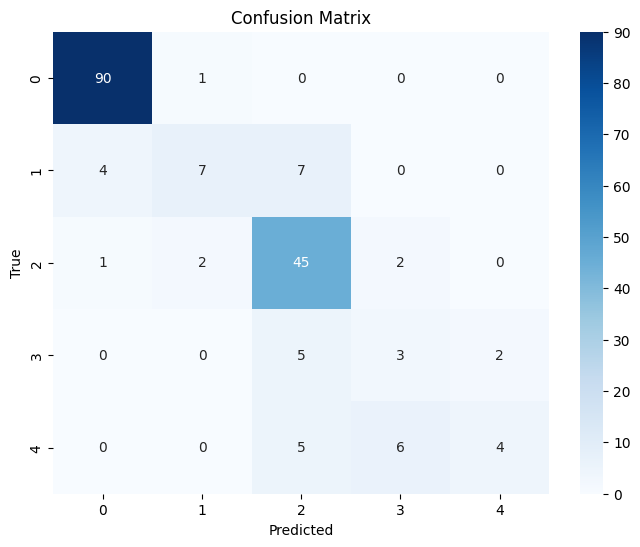

In [10]:
test_dataset = RetinopathyDataset(TEST_CSV, TEST_DATA_DIR, test_transform_en)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

num_folds = 5
all_fold_preds = []
all_true = []

for foldModel in all_models["en_models"]:
    print(f"Testing {foldModel}")

    # Load ordinal model
    model = OrdinalEfficientNetB3().to(DEVICE)
    model.load_state_dict(torch.load(all_models["en_models"][foldModel], map_location=DEVICE))
    model.eval()

    fold_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            logits = model(images)                # shape (B,4)
            preds = ordinal_decode(logits)        # shape (B,)
            fold_preds.append(preds.cpu())
            if "1" in foldModel:
                 all_true.append(labels)

    fold_preds = torch.cat(fold_preds, dim=0)     # shape (N,)
    all_fold_preds.append(fold_preds)

# ---- Ordinal Ensemble: majority vote across folds ----
stacked = torch.stack(all_fold_preds)             # shape (5, N)
ensemble_preds, _ = torch.mode(stacked, dim=0)    # majority vote

# final_preds is a vector of length N with values 0–4
final_preds = ensemble_preds

#confusion matrix
y_true = torch.cat(all_true, dim = 0)

cm = confusion_matrix(y_true, final_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Test set accuracy: 0.8098
Test set QWK: 0.9069


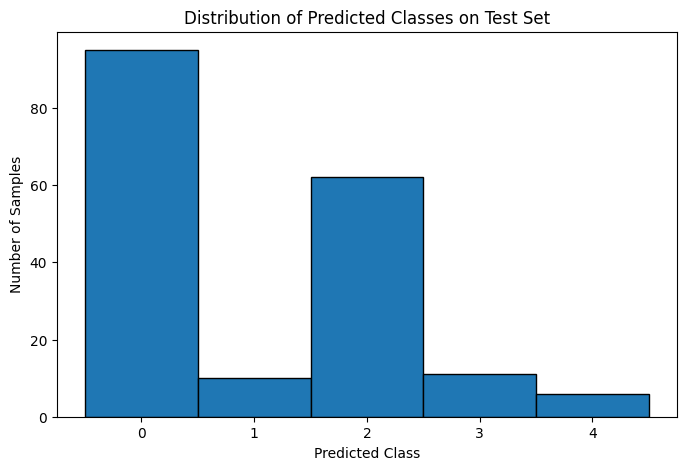

In [11]:
test_df = pd.read_csv(TEST_CSV)
# Accuracy
true_labels = torch.tensor(test_df["diagnosis"].values)
accuracy = (final_preds == true_labels).sum().item() / len(true_labels)
print(f"Test set accuracy: {accuracy:.4f}")

#QWK
y_true = true_labels.numpy() if torch.is_tensor(true_labels) else true_labels
y_pred = final_preds.numpy() if torch.is_tensor(final_preds) else final_preds

qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Test set QWK: {qwk:.4f}")

# Distribution plot
plt.figure(figsize=(8,5))
plt.hist(final_preds.numpy(), bins=np.arange(6)-0.5, edgecolor='black')
plt.xticks(range(5))
plt.xlabel("Predicted Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predicted Classes on Test Set")
plt.show()

# Inception-V3

In [ ]:
train_transform_i = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform_i = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transform_i = val_transform_i

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []
allModels["i_model"] = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df["diagnosis"])):
    print(f"\n======== Fold {fold + 1} ========")

    # Loaders for this fold
    train_loader, val_loader = get_loaders(fold, train_transform_i, val_transform_i)

    # ---- Use the new ordinal InceptionV3 ----
    model = OrdinalInceptionV3().to(DEVICE)

    # ---- Train this fold using ordinal loss ----
    score = train_one_fold_ordinal(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        fold=fold,
        lr=1e-4,
        epochs=3,
        modelType = "i",
        all_models = allModels
    )

    fold_scores.append(score)

print("QWK per fold:", fold_scores)
print("Average QWK:", np.mean(fold_scores))

In [12]:
test_dataset = RetinopathyDataset(TEST_CSV, TEST_DATA_DIR, test_transform_i)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

num_folds = 5
all_fold_preds = []
all_true = []

for foldModel in all_models["i_models"]:
    print(f"Testing {foldModel}")

    # Load ordinal model
    model = OrdinalInceptionV3().to(DEVICE)
    model.load_state_dict(torch.load(all_models["i_models"][foldModel], map_location=DEVICE))
    model.eval()

    fold_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            logits = model(images)                # shape (B,4)
            preds = ordinal_decode(logits)        # shape (B,)
            fold_preds.append(preds.cpu())
            if "1" in foldModel:
                 all_true.append(labels)

    fold_preds = torch.cat(fold_preds, dim=0)     # shape (N,)
    all_fold_preds.append(fold_preds)

# ---- Ordinal Ensemble: majority vote across folds ----
stacked = torch.stack(all_fold_preds)             # shape (5, N)
ensemble_preds, _ = torch.mode(stacked, dim=0)    # majority vote

# final_preds is a vector of length N with values 0–4
final_preds = ensemble_preds

#confusion matrix
y_true = torch.cat(all_true, dim = 0)

cm = confusion_matrix(y_true, final_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

KeyError: 'i_models'

In [ ]:
test_df = pd.read_csv(TEST_CSV)
# Accuracy
true_labels = torch.tensor(test_df["diagnosis"].values)
accuracy = (final_preds == true_labels).sum().item() / len(true_labels)
print(f"Test set accuracy: {accuracy:.4f}")

#QWK
y_true = true_labels.numpy() if torch.is_tensor(true_labels) else true_labels
y_pred = final_preds.numpy() if torch.is_tensor(final_preds) else final_preds

qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Test set QWK: {qwk:.4f}")

# Distribution plot
plt.figure(figsize=(8,5))
plt.hist(final_preds.numpy(), bins=np.arange(6)-0.5, edgecolor='black')
plt.xticks(range(5))
plt.xlabel("Predicted Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predicted Classes on Test Set")
plt.show()